In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
import numpy as np
import keras
import keras.models
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten, Reshape
from keras.layers import Input, BatchNormalization, concatenate
from keras.models import Model
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
import wandb 
from wandb.wandb_keras import WandbKerasCallback
import smiledataset

run = wandb.init()
config = run.config

config.epochs = 3
config.dropout = 0.5
config.batch_size = 128
config.lr = 1e-4
config.num_classes = 2

# load data
train_X, train_y, test_X, test_y = smiledataset.load_data()

# convert classes to vector
train_y = np_utils.to_categorical(train_y, config.num_classes)
test_y = np_utils.to_categorical(test_y, config.num_classes)

img_rows, img_cols = train_X.shape[1:]

# add additional dimension
test_X = test_X.reshape(test_X.shape[0], test_X.shape[1], test_X.shape[2], 1)
test_X = np.repeat(test_X, 3, axis=3)  #VGG19 expects input with 3 channels
train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], train_X.shape[2], 1)
train_X = np.repeat(train_X, 3, axis=3) #VGG19 expects input with 3 channels
print('train_X.shape: ', train_X.shape)
print('train_y.shape:', train_y.shape)
print('test_X.shape: ', test_X.shape)
print('test_y.shape:', test_y.shape)


shp = train_X.shape[1:]
model_vgg19_conv = keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', input_tensor=None, input_shape=shp, pooling=None, classes=2)
#model_inception_resnet_v2 = keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=config.num_classes)
model_vgg19_conv.summary()

#for layer in model_vgg19_conv.layers[:-10]:
#    print('Freezing layer: ', layer.name)
#    layer.trainable = False

datagen = ImageDataGenerator(
    rotation_range=30,
    shear_range=0.2,
    zoom_range=0.5)
#    zca_whitening=True)

#valgen = ImageDataGenerator(zca_whitening=True)


# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(train_X)
#valgen.fit(test_X)

input = Input(shape=shp, name = 'image_input')
bn1 = BatchNormalization()(input)

output_vgg19_conv = model_vgg19_conv(bn1)
block1_pool = model_vgg19_conv.get_layer('block1_pool')(bn1)
block2_pool = model_vgg19_conv.get_layer('block2_pool')(bn1)
block3_pool = model_vgg19_conv.get_layer('block3_pool')(bn1)
block4_pool = model_vgg19_conv.get_layer('block4_pool')(bn1)

block1_pool = Flatten(name='flatten_block1_pool')(block1_pool)
block2_pool = Flatten(name='flatten_block2_pool')(block2_pool)
block3_pool = Flatten(name='flatten_block3_pool')(block3_pool)
block4_pool = Flatten(name='flatten_block4_pool')(block4_pool)


block3_pool = BatchNormalization()(block3_pool)
block4_pool = BatchNormalization()(block4_pool)

#Add the fully-connected layers 
x = Flatten(name='flatten_x')(output_vgg19_conv)
x = BatchNormalization()(x)
x = keras.layers.concatenate([x, block4_pool, block3_pool]) #skip connections
x = Dropout(config.dropout)(x)
#x = BatchNormalization()(x)
x = Dense(2048, activation='relu', name='fc1')(x)
x = Dropout(config.dropout)(x)
x = Dense(1024, activation='relu', name='fc2')(x)
x = Dropout(config.dropout)(x)
#x = Dense(512, activation='relu', name='fc4')(x)
#x = Dropout(config.dropout)(x)
x = Dense(2, activation='softmax', name='predictions')(x)

#Create your own model 
model = Model(input=input, output=x)
#model.compile(keras.optimizers.Adam(lr=1e-4), loss='categorical_crossentropy')
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=config.lr), metrics=['accuracy'])
model.summary()

# checkpoint
#filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint, WandbKerasCallback()]


from shutil import copyfile
import os
import matplotlib.pyplot as plt


if os.path.isfile(filepath):
#  print('Backing up weights file')
#  copyfile(filepath, filepath + '.backup')
  print('Loading weights from ', filepath)
  model.load_weights(filepath)

predictions = model.predict(test_X, batch_size=config.batch_size, verbose=1)



/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))

wandb: wandb dryrun mode. Use "wandb run <script>" to save results to wandb.
wandb: Run directory: wandb/dryrun-20180210_075349-dtdhhr0r



train_X.shape:  (11183, 64, 64, 3)
train_y.shape: (11183, 2)
test_X.shape:  (1982, 64, 64, 3)
test_y.shape: (1982, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
________________________

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:100: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("im..., outputs=Tensor("pr...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 64, 64, 3)    12          image_input[0][0]                
__________________________________________________________________________________________________
vgg19 (Model)                   (None, 2, 2, 512)    20024384    batch_normalization_1[0][0]      
__________________________________________________________________________________________________
block4_pool (MaxPooling2D)      multiple             0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
block3_poo

[2, 27, 41, 56, 57, 59, 132, 152, 192, 257, 266, 297, 492, 502, 510, 525, 576, 582, 597, 692, 701, 726, 756, 764, 786, 795, 820, 871, 893, 903, 941, 949, 953, 956, 990, 998, 1009, 1022, 1044, 1072, 1086, 1109, 1120, 1129, 1134, 1236, 1269, 1302, 1313, 1315, 1322, 1327, 1333, 1335, 1346, 1360, 1361, 1362, 1364, 1367, 1369, 1377, 1380, 1382, 1390, 1393, 1394, 1395, 1405, 1421, 1434, 1439, 1442, 1453, 1468, 1474, 1480, 1494, 1503, 1507, 1511, 1512, 1517, 1518, 1524, 1525, 1535, 1544, 1547, 1552, 1553, 1555, 1558, 1559, 1560, 1566, 1571, 1576, 1580, 1586, 1590, 1594, 1597, 1609, 1611, 1612, 1613, 1617, 1619, 1627, 1631, 1632, 1634, 1643, 1660, 1661, 1662, 1663, 1666, 1667, 1671, 1674, 1676, 1678, 1682, 1684, 1691, 1696, 1699, 1702, 1706, 1715, 1718, 1723, 1730, 1735, 1739, 1741, 1742, 1771, 1773, 1779, 1783, 1789, 1792, 1797, 1802, 1807, 1808, 1816, 1821, 1822, 1827, 1832, 1835, 1836, 1839, 1843, 1846, 1852, 1854, 1860, 1871, 1885, 1886, 1889, 1897, 1898, 1908, 1909, 1911, 1914, 1920, 1921

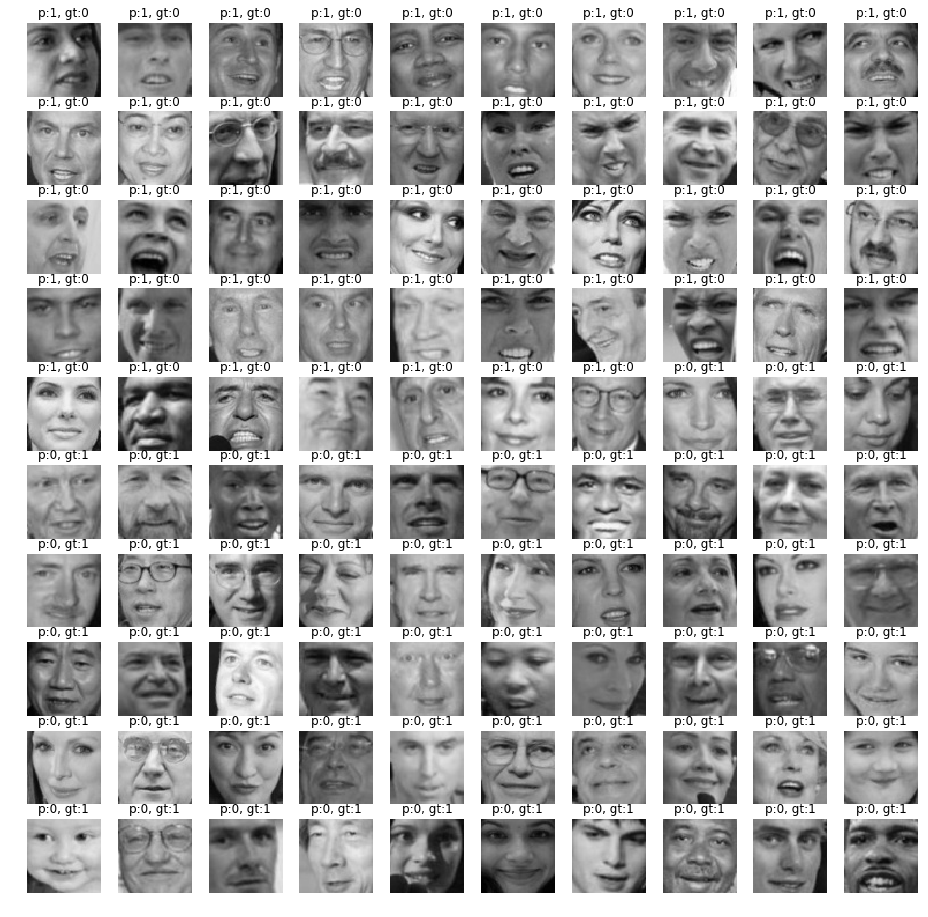

In [3]:

columns = 10
rows = 10

fp = []
for i in range(len(predictions)):
    if np.argmax(predictions[i]) != np.argmax(test_y[i]):
        fp.append(i)
print(fp)
        
fig=plt.figure(figsize=(16, 16))
for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    pred_idx = fp[i]
    p = str(np.argmax(predictions[pred_idx]))
    gt = str(np.argmax(test_y[pred_idx]))
    title = 'p:' + p + ', gt:' + gt
    ax.set_title(title)
    plt.axis('off')
    plt.imshow(255-test_X[pred_idx])


print('False Predictions [' + str(len(fp)) + ']')
plt.show()


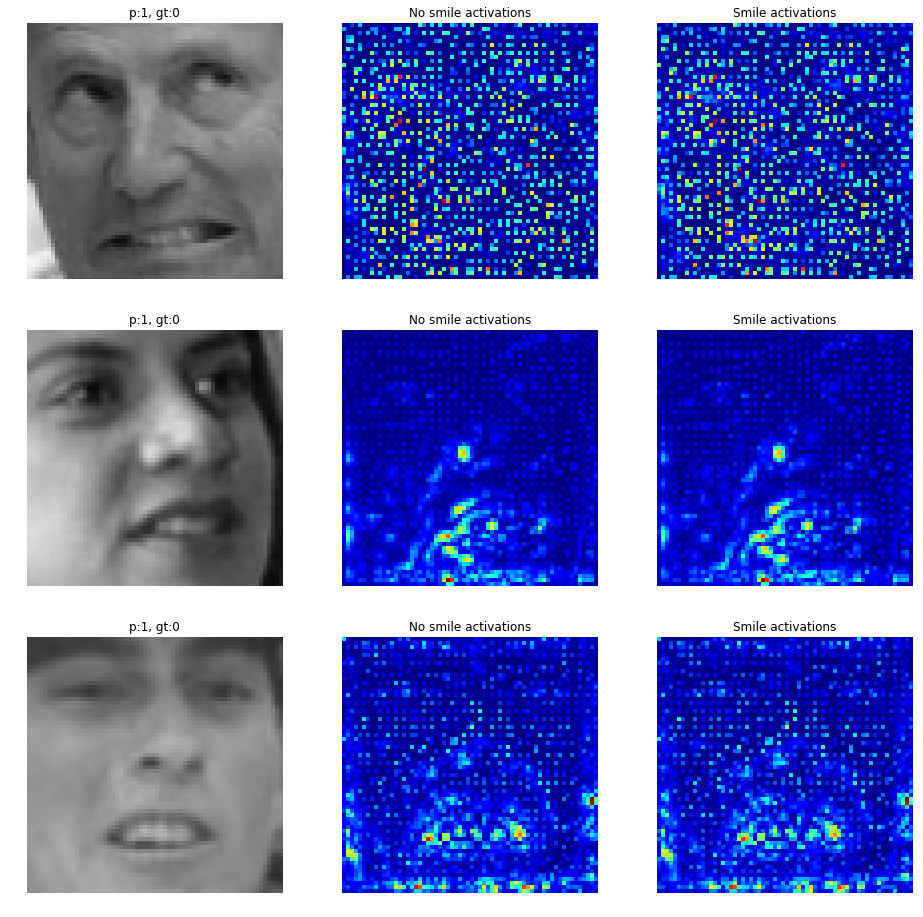

In [30]:
from vis.visualization import visualize_saliency, overlay
from vis.utils import utils
from keras import activations

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
#layer_idx = utils.find_layer_idx(model_vgg19_conv, 'block1_pool')
layer_idx = utils.find_layer_idx(model, 'predictions')

columns = 3
rows = 3

fig=plt.figure(figsize=(16, 16))
for i in range(rows):
    ax = fig.add_subplot(rows, columns, i*columns+1)
    pred_idx = fp[i]
    p = str(np.argmax(predictions[pred_idx]))
    gt = str(np.argmax(test_y[pred_idx]))
    title = 'p:' + p + ', gt:' + gt
    ax.set_title(title)
    img = 255-test_X[pred_idx]
    plt.axis('off')
    plt.imshow(img)

    ax = fig.add_subplot(rows, columns, i*columns+2)
    grads = visualize_saliency(model, layer_idx, filter_indices=0, seed_input=img, backprop_modifier='guided')
    ax.set_title('No smile activations')
    plt.axis('off')
    plt.imshow(grads, cmap='jet')

    ax = fig.add_subplot(rows, columns, i*columns+3)
    grads = visualize_saliency(model, layer_idx, filter_indices=1, seed_input=img, backprop_modifier='guided')
    ax.set_title('Smile activations')
    plt.axis('off')
    plt.imshow(grads, cmap='jet')

    



(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)


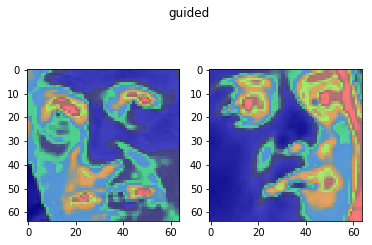

In [48]:
import numpy as np
import matplotlib.cm as cm
from vis.visualization import visualize_cam

layer_idx = utils.find_layer_idx(model, 'predictions')
img1 = 255-test_X[fp[0]]
img2 = 255-test_X[fp[1]]
for modifier in ['guided']:
    plt.figure()
    f, ax = plt.subplots(1, 2)
    plt.suptitle("vanilla" if modifier is None else modifier)
    for i, img in enumerate([img1, img2]):    
        grads = visualize_cam(model, layer_idx, filter_indices=0, 
                              seed_input=img, backprop_modifier=modifier)        
        # Lets overlay the heatmap onto original image.    
        jet_heatmap = np.uint8(cm.jet(grads)[..., 0] * 255)
        print(jet_heatmap.shape)
        print(img.shape)
        ax[i].imshow(overlay(jet_heatmap, img))

In [16]:
import sys
!{sys.executable} -m pip install imageio

In [49]:
from vis.utils import utils
from keras import activations

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'predictions')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

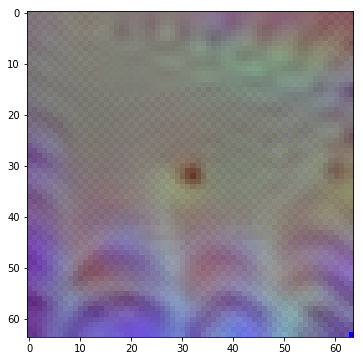

In [53]:
from vis.visualization import visualize_activation

plt.rcParams['figure.figsize'] = (18, 6)

img = visualize_activation(model, layer_idx, filter_indices=0)
plt.imshow(img)

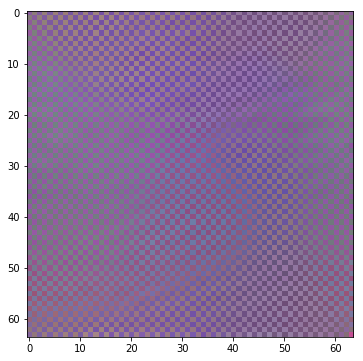

In [52]:
from vis.input_modifiers import Jitter

# 20 is the imagenet category for 'ouzel'
# Jitter 16 pixels along all dimensions to during the optimization process.
img = visualize_activation(model, layer_idx, filter_indices=0, max_iter=500, input_modifiers=[Jitter(16)])
plt.imshow(img)

In [63]:
cnt = [0, 0]
for i in range(len(train_y)):
    cnt[np.argmax(train_y[i])] += 1
    
print(cnt)

[8167, 3016]
